In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [6]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [7]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [8]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [9]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [10]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.5417      0.84948        0.266372              0.925138                  5.92701       
2           0.239354    0.930804       0.197025              0.940566                  7.71467       
3           0.180361    0.947561       0.156134              0.954213                  9.53547       
4           0.144926    0.957833       0.131461              0.959949                  11.3269       
5           0.121413    0.963869       0.121639              0.96163                   13.1248       
6           0.102957    0.969383       0.108973              0.966475                  14.9067       
7           0.089181    0.973797       0.100363              0.970233                  16.673        
8           0.0793408   0.975861       0.0944187             0.969937                  18.4409       
9           0.0702693   0.979028       0.0855501             0.97498                

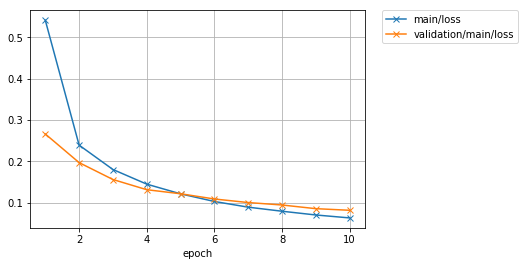

In [11]:
from IPython.display import Image
Image('mnist_result/loss.png')

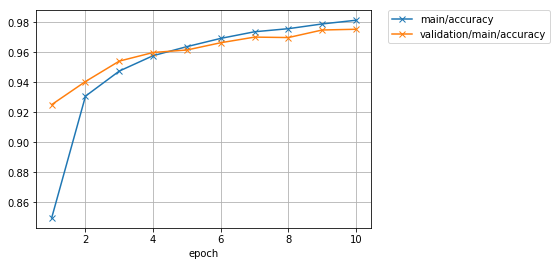

In [12]:
Image('mnist_result/accuracy.png')

label: 2
inference: 2


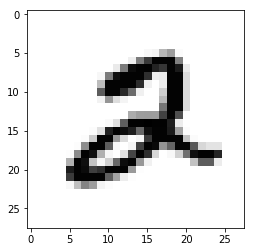

In [13]:
from IPython.display import display
model.to_cpu()
"""
学習済みモデルを使って、推論をしてみる。
serializers.save_npz('my_mnist.model',model)
"""

img_flattened, label = train[5]
img_reshaped = img_flattened.reshape(28,28)
plt.imshow(img_reshaped ,cmap='Greys')
print('label: %s' % label)

res_var = model.predictor(img_flattened.reshape(1,28*28))
res     = res_var.data.argmax()
print('inference: %s' % res)

float32
inference: 7


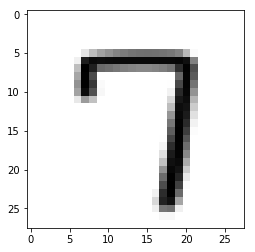

In [14]:
from PIL import Image
my_test = Image.open('7_28x28.png').convert('L')
my_test_arr = np.asarray(my_test)
my_test_arr = (1 - my_test_arr/255).astype('float32')
print(my_test_arr.dtype)
plt.imshow(my_test_arr, cmap='Greys')
res_var = model.predictor(my_test_arr.reshape(1,28*28))
res     = res_var.data.argmax()
print('inference: %s' % res)